In [181]:
import pandas as pd
import gc
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler

import tensorflow as tf

In [182]:
config = {
        # Arquitectura
        "lstm_units_1": 64,
        "lstm_units_2": 32,
        "dense_units": 16,
        "dropout_rate": 0.3,

        # Entrenamiento
        "epochs": 150,
        "batch_size": 250,
        "early_stopping_patience": 20,
        "learning_rate": None,  # Si querés usar Adam con tasa específica

        # Regularización
        "l2_lambda": 0.001,

        # Optimizador
        "optimizer": "rmsprop",  # adam, sgd, rmsprop, etc.

        # Preprocesamiento
        "scaler_name": "robust",  # standard o robust

        # Ventana temporal
        "window_size": 6,
        "feature_cols" : ['tn', 'tn_lag1', 
                          #'tn_lag6', 
                          #'tn_lag12', 
                          'tn_diff1', 
                          #'tn_diff6',
                        'rolling_mean6', 
                        'rolling_std6', 
                        # 'rolling_max3', 
                        # 'rolling_min3',
                        # 'rolling_max6',
                        # 'rolling_min6',
                        #"size"
                        ],
        "products_to_train": list(range(50)),  # Filtrar productos entre 50 y 150
    }


In [183]:
# Cargar de nuevo por claridad
df = pd.read_csv("../datasets/sell-in.txt.gz", sep="\t")
df["periodo"] = pd.to_datetime(df["periodo"], format="%Y%m")

# Agregación mensual por producto
df = df.groupby(["product_id", "periodo"]).agg({"tn": "sum"}).sort_values(["product_id", "periodo"]).reset_index()

# Crear características por producto
def agregar_features(df):
    df = df.copy()
    df = df.sort_values(["product_id", "periodo"])
    
    # Crear features con groupby + transform
    df["tn_lag1"] = df.groupby("product_id")["tn"].shift(1)
    #df["tn_lag6"] = df.groupby("product_id")["tn"].shift(6)
    #df["tn_lag12"] = df.groupby("product_id")["tn"].shift(12)

    df["tn_diff1"] = df["tn"] - df["tn_lag1"]
    #df["tn_diff6"] = df["tn"] - df["tn_lag6"]
    #df["size"] = df.groupby("product_id")["tn"].transform("size")
    

    df["rolling_mean6"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(6).mean())
    df["rolling_std6"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(6).std())
    
    # df["rolling_max3"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).max())
    # df["rolling_min3"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).min())
    # df["rolling_max6"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(6).max())
    # df["rolling_min6"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(6).min())

    return df

df_features = agregar_features(df).fillna(0)
del df
gc.collect()
print(df_features.shape)

(31243, 7)


In [184]:
df_features

,product_id,periodo,tn,tn_lag1,tn_diff1,rolling_mean6,rolling_std6
0,20001,2017-01-01,934.77222,0.00000,0.00000,0.0,0.0
1,20001,2017-02-01,798.01620,934.77222,-136.75602,0.0,0.0
2,20001,2017-03-01,1303.35771,798.01620,505.34151,0.0,0.0
3,20001,2017-04-01,1069.96130,1303.35771,-233.39641,0.0,0.0
4,20001,2017-05-01,1502.20132,1069.96130,432.24002,0.0,0.0
...,...,...,...,...,...,...,...
31238,21295,2017-01-01,0.00699,0.00000,0.00000,0.0,0.0
31239,21296,2017-08-01,0.00651,0.00000,0.00000,0.0,0.0
31240,21297,2017-01-01,0.00579,0.00000,0.00000,0.0,0.0
31241,21298,2017-08-01,0.00573,0.00000,0.00000,0.0,0.0


In [185]:
# Último período disponible
ultimo_mes = df_features["periodo"].max()

# Definir los 3 meses anteriores
ultimos_3_meses = pd.date_range(end=ultimo_mes - pd.DateOffset(months=1), periods=3, freq='MS')

# Filtrar productos con datos en al menos 3 de esos meses
df_filtrado = df_features[df_features["periodo"].isin(ultimos_3_meses)]

# Contar cuántos meses tiene cada producto
conteo_por_producto = df_filtrado[df_filtrado["tn"] > 0].groupby("product_id").size()

# Seleccionar productos válidos
productos_validos = conteo_por_producto[conteo_por_producto >= 3].index

# Filtrar el dataframe original
df_features = df_features[df_features["product_id"].isin(productos_validos)].copy()
print(df_features.shape)

(25804, 7)


In [186]:
df_test = df_features[df_features["periodo"] == pd.to_datetime(201912, format="%Y%m")].copy()
df_features[df_features["periodo"].isin(pd.to_datetime([201911, 201912], format="%Y%m")) ]

,product_id,periodo,tn,tn_lag1,tn_diff1,rolling_mean6,rolling_std6
34,20001,2019-11-01,1397.37231,1561.50552,-164.13321,1483.594937,239.063446
35,20001,2019-12-01,1504.68856,1397.37231,107.31625,1444.859933,229.267460
70,20002,2019-11-01,1423.57739,1979.53635,-555.95896,1152.218297,418.103201
71,20002,2019-12-01,1087.30855,1423.57739,-336.26884,1216.982983,426.327986
106,20003,2019-11-01,948.29393,1081.36645,-133.07252,775.408012,200.444440
...,...,...,...,...,...,...,...
31149,21267,2019-12-01,0.01569,0.04052,-0.02483,0.054910,0.027947
31189,21271,2019-11-01,0.01301,0.02453,-0.01152,0.022042,0.013669
31190,21271,2019-12-01,0.00298,0.01301,-0.01003,0.016965,0.008966
31209,21276,2019-11-01,0.03341,0.02079,0.01262,0.031320,0.032689


In [187]:
# ================================
# 2. SCALING Y VENTANAS TEMPORALES
# ================================

window_size = config["window_size"]
scaler_name = config["scaler_name"]

feature_cols = config["feature_cols"]

# Agrupar por producto
productos = df_features["product_id"].unique()
productos = list(productos)
scalers = {}  # Guardamos los scalers por producto

X, y, productos_list = [], [], []

# for producto in productos:
#     df_prod = df_features[df_features["product_id"] == producto].copy()

#     if len(df_prod) < window_size + 2:
#         continue  # No tiene suficientes datos

#     # Escalado por producto
    
#     scaler = StandardScaler() if scaler_name == "standard" else RobustScaler()
#     scaled_features = scaler.fit_transform(df_prod[feature_cols])
#     scalers[producto] = scaler

#     for i in range(window_size, len(df_prod) - 2):
#         X.append(scaled_features[i - window_size:i])  # (window_size, n_features)
#         y.append(scaled_features[i + 2][0])  # Target: tn escalado en t+2
#         productos_list.append(producto)

# X = np.array(X)
# y = np.array(y).reshape(-1, 1)

In [188]:

# ================================
# 3. TRAIN / TEST SPLIT
# ================================
from sklearn.model_selection import train_test_split

# productos_train, productos_test = train_test_split(np.unique(productos_list), test_size=0.2, random_state=42)

# train_mask = [p in productos_train for p in productos_list]
# test_mask = [p in productos_test for p in productos_list]

# X_train, X_test = X[train_mask], X[test_mask]
# y_train, y_test = y[train_mask], y[test_mask]

# Primero reconstruimos la lista de periodos asociados a cada muestra
productos = df_features["product_id"].unique()
scalers = {}
X, y, productos_list = [], [], []
periodos = []
# Filtrar productos a entrenar
products_to_train = config["products_to_train"]
if products_to_train:
    products_to_train  = productos[config["products_to_train"]]
else:
    products_to_train = productos
    
    
for producto in productos:
    if producto not in products_to_train: # filtro por productos a entrenar
        continue  # Solo entrenamos con estos

    df_prod = df_features[df_features["product_id"] == producto].copy()

    if len(df_prod) < window_size + 2:
        continue

    scaler = StandardScaler() if scaler_name == "standard" else RobustScaler()
    scaled_features = scaler.fit_transform(df_prod[feature_cols])
    scalers[producto] = scaler

    for i in range(window_size, len(df_prod) - 2):
        X.append(scaled_features[i - window_size:i])
        y.append(scaled_features[i + 2][0])
        productos_list.append(producto)
        periodo_target = df_prod.iloc[i + 2]["periodo"]
        periodos.append(periodo_target)

In [189]:
X = np.array(X)
y = np.array(y).reshape(-1, 1)
productos_list = np.array(productos_list)
periodos = np.array(periodos)

# Ahora sí, aplicá las máscaras
train_mask = periodos < pd.to_datetime("2019-12-01")
test_mask = periodos == pd.to_datetime("2019-12-01")

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]
productos_test = productos_list[test_mask]


In [190]:

# ================================
# 4. MODELO LSTM
# ================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau





l2_lambda = config["l2_lambda"]
optimizer = config["optimizer"]
epochs = config["epochs"]
batch_size = config["batch_size"]
early_stopping_patience = config["early_stopping_patience"]


def get_reg(l2_lambda):
    return l2(l2_lambda) if l2_lambda > 0 else None

n_features = X.shape[2]

model = Sequential([
    LSTM(200, activation='tanh', return_sequences=True, input_shape=(window_size, n_features),
         kernel_regularizer=get_reg(l2_lambda)),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

callbacks = [
    EarlyStopping(patience=early_stopping_patience, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=15)
]

model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)


Epoch 1/150
6/6 [==============================] - 5s 211ms/step - loss: 0.5885 - mae: 0.5793 - val_loss: 0.5974 - val_mae: 0.5891 - lr: 0.0010
Epoch 2/150
6/6 [==============================] - 0s 35ms/step - loss: 0.5744 - mae: 0.5665 - val_loss: 0.5947 - val_mae: 0.5873 - lr: 0.0010
Epoch 3/150
6/6 [==============================] - 0s 34ms/step - loss: 0.5659 - mae: 0.5588 - val_loss: 0.5485 - val_mae: 0.5418 - lr: 0.0010
Epoch 4/150
6/6 [==============================] - 0s 29ms/step - loss: 0.5619 - mae: 0.5554 - val_loss: 0.5700 - val_mae: 0.5638 - lr: 0.0010
Epoch 5/150
6/6 [==============================] - 0s 26ms/step - loss: 0.5550 - mae: 0.5489 - val_loss: 0.5329 - val_mae: 0.5270 - lr: 0.0010
Epoch 6/150
6/6 [==============================] - 0s 26ms/step - loss: 0.5508 - mae: 0.5451 - val_loss: 0.5318 - val_mae: 0.5263 - lr: 0.0010
Epoch 7/150
6/6 [==============================] - 0s 26ms/step - loss: 0.5481 - mae: 0.5427 - val_loss: 0.5424 - val_mae: 0.5372 - lr: 0.001

In [191]:
# ================================
# 5. PREDICCIÓN t+2
# ================================

def predecir_t2(product_id, df_features_full):
    """
    product_id: ID del producto a predecir.
    df_features_full: dataframe con las features ya procesadas.
    """
    df_prod = df_features_full[df_features_full["product_id"] == product_id].copy()
    scaler = scalers[product_id]

    ultimos = df_prod[feature_cols].iloc[-window_size:]
    ultimos_scaled = scaler.transform(ultimos)

    X_new = ultimos_scaled.reshape(1, window_size, len(feature_cols))
    y_pred_scaled = model.predict(X_new)

    # Inversión del escalado solo sobre la primera columna (tn)
    tn_mean = scaler.center_[0]
    tn_std = scaler.scale_[0]

    y_pred = y_pred_scaled[0][0] * tn_std + tn_mean
    return y_pred

In [192]:
# def predecir_todos_t2(df_features_full, model, scalers, feature_cols, window_size):
#     """
#     Predice tn en t+2 para todos los productos que tengan suficientes datos.

#     Args:
#         df_features_full (pd.DataFrame): dataframe completo con features
#         model: modelo LSTM ya entrenado
#         scalers (dict): diccionario con los StandardScaler por producto
#         feature_cols (list): lista de columnas de features
#         window_size (int): tamaño de la ventana temporal

#     Returns:
#         pd.DataFrame: dataframe con columnas ["product_id", "tn_t2_pred"]
#     """
#     productos = df_features_full["product_id"].unique()
#     resultados = []

#     for pid in productos:
#         y_pred = None
#         df_prod = df_features_full[df_features_full["product_id"] == pid]

#         if len(df_prod) < window_size:
#             continue  # no hay suficientes datos

#         try:
#             ultimos = df_prod[feature_cols].iloc[-window_size:]
#             scaler = scalers[pid]
#             ultimos_scaled = scaler.transform(ultimos)

#             X_new = ultimos_scaled.reshape(1, window_size, len(feature_cols))
#             y_pred_scaled = model.predict(X_new, verbose=0)

#             # Desescalar
#             tn_mean = scaler.center_[0]
#             tn_std = scaler.scale_[0]
#             y_pred = y_pred_scaled[0][0] * tn_std + tn_mean

            

#         except Exception as e:
#             print(f"Error al predecir producto {pid}: {e}")
            
#         if y_pred is None or y_pred < 0:
#             y_pred = np.mean(df_prod["tn"])  # Valor por defecto si falla la predicción
#         resultados.append({"product_id": pid, "tn_t2_pred": y_pred})

#     return pd.DataFrame(resultados)

def predecir_todos_t2(df_features_full, model, scalers, feature_cols, window_size):
    productos = df_features_full["product_id"].unique()
    resultados = []

    for pid in productos:
        df_prod = df_features_full[df_features_full["product_id"] == pid]
        if len(df_prod) < window_size:
            continue

        try:
            ultimos = df_prod[feature_cols].iloc[-window_size:]
            
            # Ajustar un scaler si el producto no está en scalers
            if pid not in scalers:
                scaler = StandardScaler() if scaler_name == "standard" else RobustScaler()
                scaler.fit(df_prod[feature_cols])
                scalers[pid] = scaler
            else:
                scaler = scalers[pid]

            ultimos_scaled = scaler.transform(ultimos)
            X_new = ultimos_scaled.reshape(1, window_size, len(feature_cols))
            y_pred_scaled = model.predict(X_new, verbose=0)

            tn_mean = scaler.center_[0] if hasattr(scaler, "center_") else scaler.mean_[0]
            tn_std = scaler.scale_[0]
            y_pred = y_pred_scaled[0][0] * tn_std + tn_mean

        except Exception as e:
            print(f"Error al predecir producto {pid}: {e}")
            y_pred = np.nan

        if y_pred is None or y_pred < 0 or np.isnan(y_pred):
            y_pred = df_prod["tn"].tail(3).mean()

        resultados.append({"product_id": pid, "tn_t2_pred": y_pred})

    return pd.DataFrame(resultados)



In [193]:
df_preds_t2 = predecir_todos_t2(
    df_features_full=df_features,
    model=model,
    scalers=scalers,
    feature_cols=feature_cols,
    window_size=window_size
)

print(df_preds_t2.head())

   product_id   tn_t2_pred
0       20001  1411.896511
1       20002  1057.036440
2       20003   735.108793
3       20004   523.092698
4       20005   553.501050


In [194]:
df_preds_t2

,product_id,tn_t2_pred
0,20001,1411.896511
1,20002,1057.036440
2,20003,735.108793
3,20004,523.092698
4,20005,553.501050
...,...,...
869,21265,0.065776
870,21266,0.069656
871,21267,0.068660
872,21271,0.014100


In [195]:
df_final = df_test.merge(df_preds_t2, on="product_id", how="left")
df_final

,product_id,periodo,tn,tn_lag1,tn_diff1,rolling_mean6,rolling_std6,tn_t2_pred
0,20001,2019-12-01,1504.68856,1397.37231,107.31625,1444.859933,229.267460,1411.896511
1,20002,2019-12-01,1087.30855,1423.57739,-336.26884,1216.982983,426.327986,1057.036440
2,20003,2019-12-01,892.50129,948.29393,-55.79264,835.102808,187.119671,735.108793
3,20004,2019-12-01,637.90002,723.94206,-86.04204,707.642135,210.228042,523.092698
4,20005,2019-12-01,593.24443,606.91173,-13.66730,773.672883,176.802640,553.501050
...,...,...,...,...,...,...,...,...
875,21265,2019-12-01,0.05007,0.06600,-0.01593,0.048168,0.035791,0.065776
876,21266,2019-12-01,0.05121,0.06713,-0.01592,0.056698,0.036011,0.069656
877,21267,2019-12-01,0.01569,0.04052,-0.02483,0.054910,0.027947,0.068660
878,21271,2019-12-01,0.00298,0.01301,-0.01003,0.016965,0.008966,0.014100


In [196]:
numerador = (df_final["tn"]- df_final["tn_t2_pred"]).abs().sum()
denominador = df_final["tn"].sum()
porcentaje_error = (numerador / denominador)
porcentaje_error

0.2507212404907355

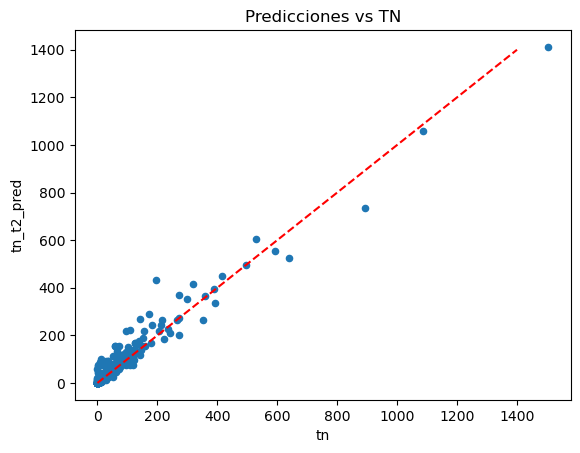

In [197]:
import matplotlib.pyplot as plt
df_final.plot(kind="scatter", x="tn", y="tn_t2_pred", title="Predicciones vs TN")
plt.plot([0, 1400], [0, 1400], 'r--')
plt.show()

In [198]:
import plotly.graph_objects as go

# Crear el gráfico de dispersión
fig = go.Figure()

# Añadir los puntos de dispersión con el product_id en el hover
fig.add_trace(go.Scatter(
    x=df_final["tn"],
    y=df_final["tn_t2_pred"],
    mode='markers',
    name='Datos',
    customdata=df_final["product_id"],  # Pasamos el product_id como dato adicional
    hovertemplate=(
        "<b>TN Real</b>: %{x}<br>"
        "<b>TN Predicho</b>: %{y}<br>"
        "<b>Product ID</b>: %{customdata}<br>"
        "<extra></extra>"  # Elimina información adicional automática
    ),
    marker=dict(size=8, opacity=0.7)  # Opcional: ajustar tamaño y transparencia
))

# Añadir la línea de referencia y=x
fig.add_trace(go.Scatter(
    x=[0, 1400],
    y=[0, 1400],
    mode='lines',
    name='y = x',
    line=dict(color='red', dash='dash')
))

# Configurar el diseño del gráfico para que sea cuadrado
fig.update_layout(
    title='Predicciones vs TN',
    xaxis_title='TN Real',
    yaxis_title='TN Predicho',
    showlegend=True,
    # Forzar misma escala en ejes X e Y
    xaxis=dict(scaleanchor="y", scaleratio=1),
    yaxis=dict(scaleanchor="x", scaleratio=1),
    # Tamaño cuadrado (opcional)
    width=600,
    height=600,
    # Rango fijo para ambos ejes (opcional)
    xaxis_range=[0, 50],
    yaxis_range=[0, 50]
)

# Mostrar el gráfico
fig.show()

In [199]:
print(df_final["tn_t2_pred"].sum(),"|",df_final["tn"].sum())

29100.052710900178 | 25987.52668


In [200]:
df_final["error"] = (df_final["tn"] - df_final["tn_t2_pred"]).abs()
df_final["error_relativo"] = df_final["error"] / df_final["tn"]
df_final.sort_values(by="error", ascending=False, inplace=True)
df_final[["product_id" ,"tn", "tn_t2_pred", "error", "error_relativo"]].head(20)


,product_id,tn,tn_t2_pred,error,error_relativo
7,20008,195.36854,434.461315,239.092775,1.223804
2,20003,892.50129,735.108793,157.392497,0.176350
17,20018,141.63570,267.818399,126.182699,0.890896
32,20033,96.76212,218.480403,121.718283,1.257913
11,20012,173.13004,288.207805,115.077765,0.664690
3,20004,637.90002,523.092698,114.807322,0.179977
27,20028,109.92618,224.351954,114.425774,1.040933
44,20048,58.89241,156.960632,98.068222,1.665210
12,20013,318.09141,416.041146,97.949736,0.307930
40,20044,59.61747,155.831132,96.213662,1.613850


In [201]:
sellin = pd.read_csv("../datasets/sell-in.txt.gz", sep="\t")

C:\Users\carre\AppData\Local\Temp\ipykernel_6408\804960764.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



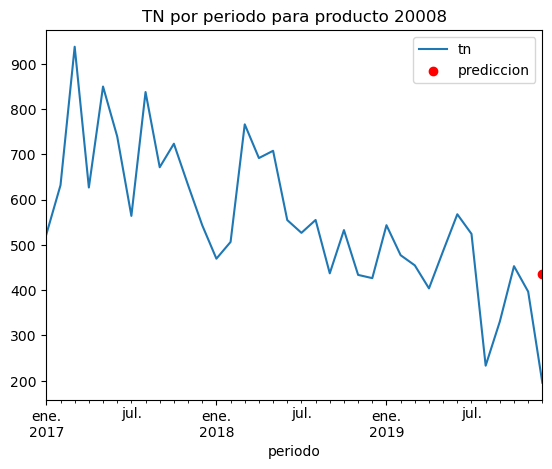

In [202]:

prod = 20008
prod_s = sellin[sellin["product_id"] == prod]
prod_s["periodo"] = pd.to_datetime(prod_s["periodo"], format='%Y%m')
prod_s = prod_s.groupby("periodo").agg({"tn": "sum"}).reset_index()
#prod_s.plot(kind="line", x="periodo", y="tn", title="TN por periodo para producto 20002")

import matplotlib.pyplot as plt

ax = plt.gca()
prod_s.plot(kind="line", x="periodo", y="tn", title=f"TN por periodo para producto {prod}", ax=ax)
#plt.axhline(y=813.82, color='red', linestyle='--', label='predict')
prediccion = df_final[df_final["product_id"] == prod]["tn_t2_pred"].values[0]
plt.scatter(prod_s["periodo"].iloc[-1], prediccion, color='red', label='prediccion')
plt.legend()
plt.show()

In [203]:
df_final["volumen_cuartil"] = pd.qcut(df_final["tn"], q=10, labels=False)


In [204]:
print(df_final.groupby("volumen_cuartil")[["error"]].sum())

                       error
volumen_cuartil             
0                 167.431886
1                 162.293162
2                 153.570892
3                 110.544785
4                 209.589166
5                 361.853159
6                 410.619047
7                 527.811250
8                1402.620282
9                3009.291298
